In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
bonds = screen_funds('Bonds', 'Leveraged Debt', min_assets=.01, max_expense=1.1)
equities = screen_funds('Equities', 'Leveraged Equity', min_assets=.01, max_expense=1.1)
print(len(bonds), len(equities))
quote = Quote(bonds + equities, 126, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

4 50
from 2019-01-28 to 2019-07-26 - 54


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

44


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
SOXL,122,0.520790,2.124005,0.241456,86.901760,47.161159
NUGT,122,0.484544,2.333955,0.204206,79.566001,38.507809
JNUG,122,0.382412,2.805138,0.133496,55.453638,50.478040
TQQQ,122,0.369854,1.207090,0.299826,62.595371,30.499706
GDXX,122,0.344360,1.557234,0.216039,53.049913,26.905945
ROM,122,0.323295,0.923805,0.341369,53.601315,24.812499
USD,122,0.320968,1.411731,0.221736,47.691443,37.468942
FAS,122,0.285437,0.940570,0.295034,45.231068,14.333784
SPXL,122,0.285269,0.906520,0.305930,46.974565,19.502869


evicted EET 0.786 -0.239
evicted UYM 0.742 -0.338
evicted DRN 0.695 -0.082
evicted RXL 0.580 -0.082
evicted INDL 0.385 -0.145
evicted UPW 0.280 -0.121
evicted DFEN 0.611 -0.342
evicted CHAU 0.510 -0.333
evicted RUSL 0.408 -0.123
evicted SOXL 0.766 -0.422
evicted GDXX 0.363 -0.160
retry backlogs ['URTY', 'TQQQ', 'TNA', 'TMF', 'MIDU', 'MVV', 'UPRO', 'SPXL', 'EURL', 'QLD', 'URE', 'SSO', 'UDOW', 'UMDD', 'FINU', 'SAA', 'UYG', 'CURE', 'JPNL', 'NUGT', 'DZK', 'PPLC', 'DDM', 'UXI', 'UWM', 'USD', 'UST', 'JNUG', 'TYD', 'UCC', 'FAS'] at 0.805/-0.51 - 0.537
evicted URE 0.579 -0.026
evicted CURE 0.584 -0.083
evicted UXI 0.793 -0.445
evicted USD 0.784 -0.422
evicted NUGT 0.474 -0.162
retry backlogs ['URTY', 'DDM', 'TQQQ', 'EURL', 'TNA', 'FINU', 'UYG', 'MVV', 'MIDU', 'UMDD', 'UPRO', 'SPXL', 'SAA', 'PPLC', 'QLD', 'JPNL', 'UWM', 'SSO', 'UBT', 'DZK', 'UDOW', 'JNUG', 'UST', 'UCC', 'TYD', 'FAS'] at 0.810/-0.52 - 0.602
evicted JNUG 0.436 -0.144
retry backlogs ['TQQQ', 'URTY', 'DDM', 'UYG', 'PPLC', 'MVV', 'S

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,122.0,0.257652,0.418231,-0.999442,-0.007594,0.224650,0.552969,1.354560,0.597077,40.602753,5.496101
ROM,122.0,0.323295,0.923805,-2.798820,-0.132120,0.382486,0.866503,3.204868,0.341369,53.601315,24.812499
TMF,122.0,0.204396,0.728284,-1.888454,-0.180439,0.154314,0.648541,2.226617,0.269756,29.924516,9.129596


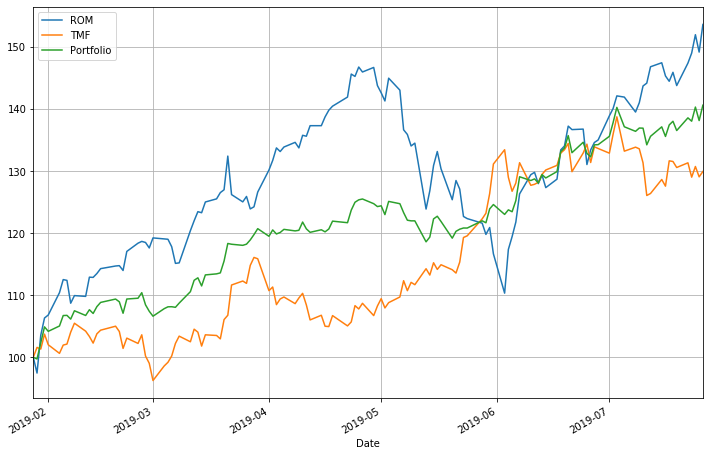

In [5]:
bounds = .24, .32
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(max_count=2, backlogs_pos_threshold=.8, _lambda=-1, bounds=bounds)
quote.setup_mask(['TMF', 'ROM'])
sd.update(quote.optimize_portfolio(max_count=2, _lambda=-1, bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(max_count=2, _lambda=-1, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,122.0,0.257652,0.418231,-0.999442,-0.007594,0.224650,0.552969,1.354560,0.597077,40.602753,5.496101
ROM,122.0,0.323295,0.923805,-2.798820,-0.132120,0.382486,0.866503,3.204868,0.341369,53.601315,24.812499
TMF,122.0,0.204396,0.728284,-1.888454,-0.180439,0.154314,0.648541,2.226617,0.269756,29.924516,9.129596


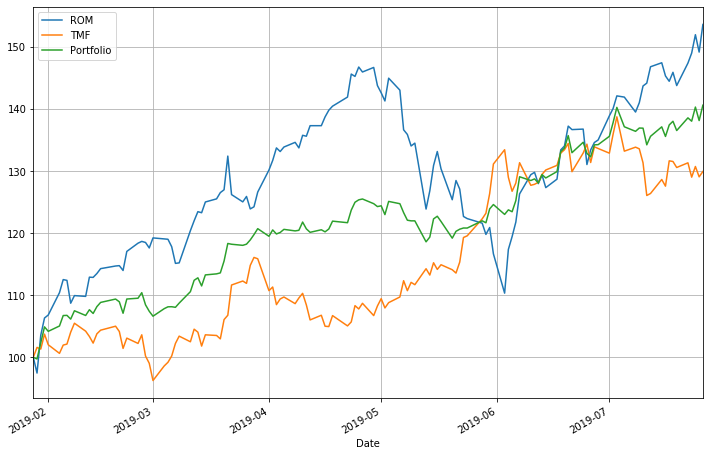

In [6]:
quote.setup_mask(['TMF', 'ROM'])
quote.graph({'ROM': 0.451, 'TMF': 0.549})